# Objective- Apply DecisionTreeClassifier on amazon fine food review( bag of word and tfidf)

codes for-
1. finding the best max depth hyperparameter using GridSearchCV for featurization like bag of words, tfidf, avg word2vec and tfidf word2vec
2. plotting depth vs mse for every cv
3. feature importance


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading the data

In [2]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
import sqlite3
import numpy as np
import pandas as pd

In [7]:
sql_data=sqlite3.connect('database.sqlite')
data=pd.read_sql_query('''
SELECT *
FROM Reviews
WHERE Score!=3''',sql_data)

In [8]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [9]:
def pos_neg(x):
    if x<3:
        return 0
    else:
        return 1
data['Score']=data['Score'].map(pos_neg)

In [10]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Cleaning

In [11]:
data=data[data['HelpfulnessNumerator']<=data['HelpfulnessDenominator']]
data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=True)  #dropping the duplicates in the datasets

In [12]:
data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [17]:
#sampling the data
data=data.sort_values(['Time'])#time based sorting 
sample_data=data.iloc[:100000]  #taking 100k datapoints
sample_score=sample_data['Score']

In [19]:
import nltk
from nltk.corpus import stopwords
import re

stop=set(stopwords.words('english'))   #stopwords of english language
sno=nltk.stem.SnowballStemmer('english')  #stemmer of english language

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [20]:
#filtering sentence
final_string=[]
s=''
for sentence in sample_data['Text']:
    filtered_sentence=[]
    cleaned_sentence=cleanhtml(sentence)
    for words in sentence.split():
        cleaned_words=cleanpunc(words)
        if ( (cleaned_words.isalpha()) & (len(cleaned_words)>2) ):
            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
            else: 
                continue
        else:
            continue
    str1=b" ".join(filtered_sentence)    
    final_string.append(str1)
        

In [21]:
sample_data['Cleaned_text']=final_string

In [15]:
sample_data.to_csv('sample_tree.csv')

In [5]:
sample_data=pd.read_csv('sample_tree.csv')

In [7]:
#taking the test data seperate from all other

X, x_test, y_train, y_test=train_test_split(sample_data['Cleaned_text'], sample_data['Score'], test_size=0.3) #splitting the data

##  Decision Tree Classifier for BoW, scoring='f1' 

In [8]:

count_vec=CountVectorizer()
x_train_bow=count_vec.fit_transform(X.values)
x_test_bow=count_vec.transform(x_test.values)

In [9]:
print('number of dimensions in unigram bag of words--')
len(count_vec.get_feature_names())

number of dimensions in unigram bag of words--


27875

In [10]:
#this function finds max depth hyperparameter using GridSearchCV, accuracy, plot mse vs depth, confusion matrix and classification report
# this function returns accuracy, optimal depth, TNR, TPR, FNR, FPR

from scipy.stats import randint

def cross_val(scoring, n_jobs, x_train, x_test, y_train=y_train, y_test=y_test, n=20):
    depth=sorted(randint(1,400).rvs(n))
    #depth=list(range(1,n, gap))
    cv_score=[]
    start=datetime.now()
    param={'max_depth':depth}
    tscv=TimeSeriesSplit(n_splits=10)
    clf=DecisionTreeClassifier()
    clf=GridSearchCV(estimator=clf, param_grid=param, scoring=scoring, n_jobs=n_jobs, cv=tscv, verbose=1)
    clf.fit(x_train,y_train)
    end=datetime.now()
    print('duration in cross validation=',(end-start))
    print('**********************************************************************\n')
    optimal_depth=clf.best_estimator_.get_params()['max_depth']
    print('optimal depth',optimal_depth)
    
    print('**********************************************************************\n')
        
    # finding precision error and optimal depth
    mse=[]
    for x in clf.grid_scores_:
        mse.append(1-x[1])
    
    #ploting precision error vs depth
    plt.figure(figsize=(8,8))
    plt.plot(depth,mse)
    plt.xlabel('depth')
    plt.ylabel('misclassification error')
    plt.title('plot between depth vs error')
    plt.show()
    print('**********************************************************************\n')
    
        
    y_pred=clf.predict(x_test)
    accu=accuracy_score(y_test,y_pred)*100
    print('accuracy=',accu)
    print('**********************************************************************\n')
    
    #confusion matrix
    t=confusion_matrix(y_pred,y_test)
    print('confusion matrix--')
    #print(t)
    #print('**********************************************************************')
    sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('confusion matrix')
    plt.show()
    print('**********************************************************************\n')
    
    # finding TPR , TNR, FPR, FNR
    TNR=t[0][0]/(t[0][0]+t[1][0])
    TPR=t[1][1]/(t[0][1]+t[1][1])
    FPR=t[1][0]/(t[0][0]+t[1][0])
    FNR=t[0][1]/(t[0][1]+t[1][1])
    print('TNR=',TNR)
    print('TPR=',TPR)
    print('FPR=',FPR)
    print('FNR=',FNR)
    print('**********************************************************************\n')
    
    
    #classification report
    print(classification_report(y_pred,y_test))
    print('**********************************************************************\n')
      
    
    return optimal_depth, accu, TNR, TPR, FPR, FNR

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.5min finished


duration in cross validation= 0:06:11.705973
**********************************************************************

optimal depth 62
**********************************************************************



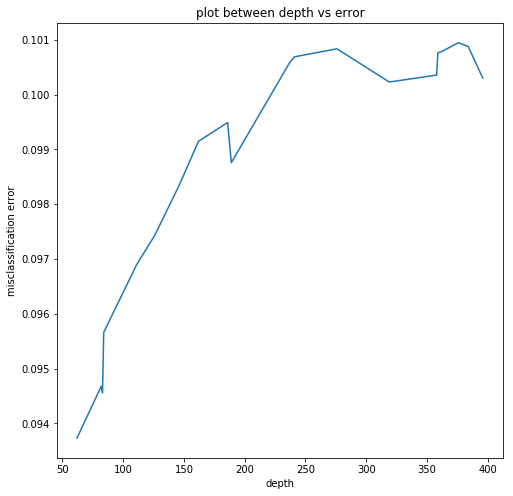

**********************************************************************

accuracy= 84.79666666666667
**********************************************************************

confusion matrix--


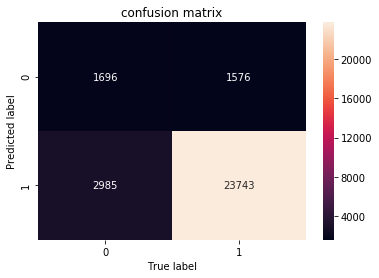

**********************************************************************

TNR= 0.3623157444990387
TPR= 0.9377542556973024
FPR= 0.6376842555009613
FNR= 0.06224574430269758
**********************************************************************

             precision    recall  f1-score   support

          0       0.36      0.52      0.43      3272
          1       0.94      0.89      0.91     26728

avg / total       0.87      0.85      0.86     30000

**********************************************************************



In [11]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val(scoring='f1', n_jobs=-1, x_train=x_train_bow, x_test=x_test_bow)

In [12]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(x_train_bow,y_train)
print('top 25 words and their IG---')
print('---------------------------------')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
feature=count_vec.get_feature_names()
for i in range(25):
    index=s[i]
    print(feature[index],'\t\t:\t\t',round(top[index],5))

top 25 words and their IG---
---------------------------------
throw 		:		 0.00545
aw 		:		 0.00555
use 		:		 0.0057
nice 		:		 0.00577
excel 		:		 0.0058
thought 		:		 0.00597
product 		:		 0.00652
descript 		:		 0.00669
didnt 		:		 0.00669
favorit 		:		 0.00681
would 		:		 0.00746
bad 		:		 0.00783
horribl 		:		 0.00787
perfect 		:		 0.00842
delici 		:		 0.00915
tast 		:		 0.00928
good 		:		 0.01029
threw 		:		 0.01372
best 		:		 0.01492
worst 		:		 0.01693
love 		:		 0.02065
return 		:		 0.02221
wast 		:		 0.02748
great 		:		 0.02813
disappoint 		:		 0.03601


##  Decision Tree Classifier for BoW, scoring='accuracy' 

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.5min finished


duration in cross validation= 0:06:34.736945
**********************************************************************

optimal depth 12
**********************************************************************



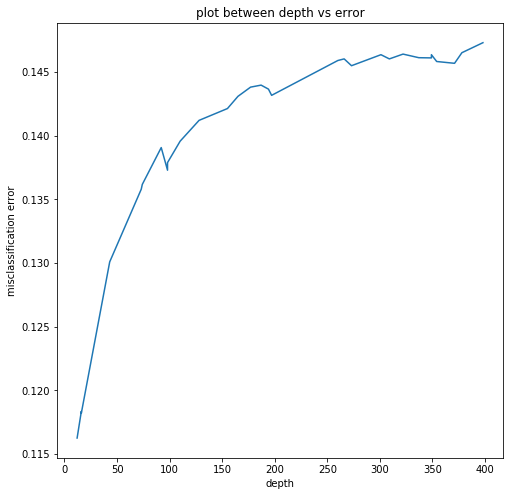

**********************************************************************

accuracy= 88.70333333333333
**********************************************************************

confusion matrix--


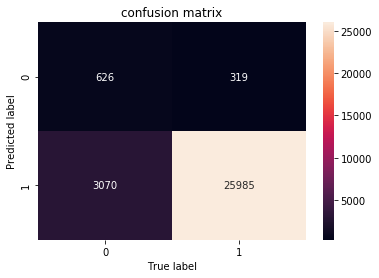

**********************************************************************

TNR= 0.16937229437229437
TPR= 0.9878725669099757
FPR= 0.8306277056277056
FNR= 0.012127433090024332
**********************************************************************

             precision    recall  f1-score   support

          0       0.17      0.66      0.27       945
          1       0.99      0.89      0.94     29055

avg / total       0.96      0.89      0.92     30000

**********************************************************************



In [121]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val( scoring='accuracy', n_jobs=-1, x_train=x_train_bow, x_test=x_test_bow)

In [122]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(x_train_bow,y_train)
print('top 25 words and their IG---')
print('---------------------------------')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
feature=count_vec.get_feature_names()
for i in range(25):
    index=s[i]
    print(feature[index],'\t\t:\t\t',round(top[index],5))

top 25 words and their IG---
---------------------------------
receiv 		:		 0.00455
make 		:		 0.00465
alway 		:		 0.00494
add 		:		 0.00565
money 		:		 0.0059
product 		:		 0.006
contact 		:		 0.00606
use 		:		 0.00641
like 		:		 0.0074
refund 		:		 0.00749
delici 		:		 0.0079
thought 		:		 0.01308
good 		:		 0.01354
bad 		:		 0.01728
didnt 		:		 0.02174
would 		:		 0.02723
horribl 		:		 0.03608
return 		:		 0.05174
love 		:		 0.05647
threw 		:		 0.06168
best 		:		 0.06783
wast 		:		 0.07118
worst 		:		 0.08631
great 		:		 0.08926
disappoint 		:		 0.09845


### Observation-
* we can choose max_depth=62 as a best hyperparameter for BoW

#### saving graph

In [13]:
import graphviz
from sklearn import tree
clf=DecisionTreeClassifier(max_depth=62)
clf.fit(x_train_bow,y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=62,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [14]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("graph_bow") 


'graph_bow.pdf'

## Decision tree classifier on TfidfVectorizer, scoring='accuracy'

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf_vect.fit_transform(X.values)
x_test_tfidf=tfidf_vect.transform(x_test.values)

In [16]:
print('number of dimensions in tfidf ---')
print(len(tfidf_vect.get_feature_names()))

number of dimensions in tfidf ---
27875


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.3min finished


duration in cross validation= 0:07:18.792471
**********************************************************************

optimal depth 6
**********************************************************************



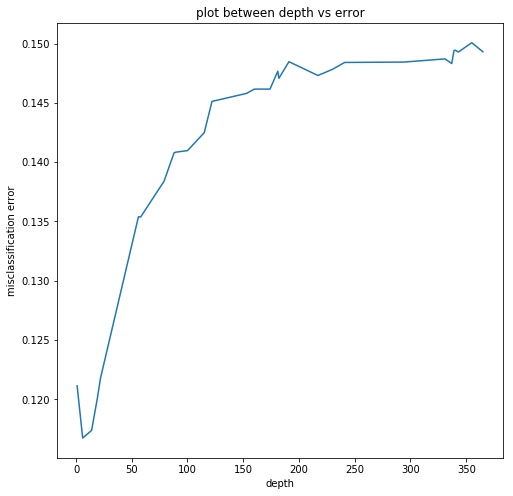

**********************************************************************

accuracy= 88.48333333333333
**********************************************************************

confusion matrix--


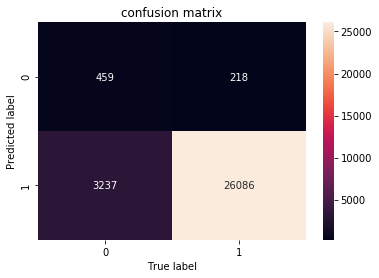

**********************************************************************

TNR= 0.1241883116883117
TPR= 0.9917122871046229
FPR= 0.8758116883116883
FNR= 0.00828771289537713
**********************************************************************

             precision    recall  f1-score   support

          0       0.12      0.68      0.21       677
          1       0.99      0.89      0.94     29323

avg / total       0.97      0.88      0.92     30000

**********************************************************************



In [163]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val(scoring='accuracy', n_jobs=-1,  x_train=x_train_tfidf, x_test=x_test_tfidf)

In [164]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(x_train_tfidf,y_train)
print('top 25 words and their IG---')
print('---------------------------------')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
feature=tfidf_vect.get_feature_names()
for i in range(25):
    index=s[i]
    print(feature[index],'\t\t:\t\t',round(top[index],5))

top 25 words and their IG---
---------------------------------
bean 		:		 0.00215
wish 		:		 0.00234
near 		:		 0.00242
flavor 		:		 0.00249
call 		:		 0.00278
item 		:		 0.00292
bad 		:		 0.00337
worth 		:		 0.00357
money 		:		 0.00379
take 		:		 0.0044
product 		:		 0.00492
return 		:		 0.0053
ever 		:		 0.00629
use 		:		 0.00636
thought 		:		 0.00746
find 		:		 0.00858
add 		:		 0.00956
best 		:		 0.0145
delici 		:		 0.01491
love 		:		 0.10257
threw 		:		 0.12799
wast 		:		 0.13233
great 		:		 0.15985
worst 		:		 0.16429
disappoint 		:		 0.17976


## Decision tree classifier on TfidfVectorizer, scoring='f1'

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.1min finished


duration in cross validation= 0:10:03.910526
**********************************************************************

optimal depth 79
**********************************************************************



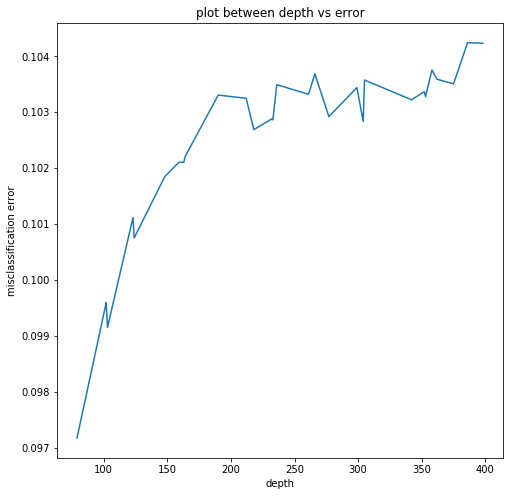

**********************************************************************

accuracy= 84.14
**********************************************************************

confusion matrix--


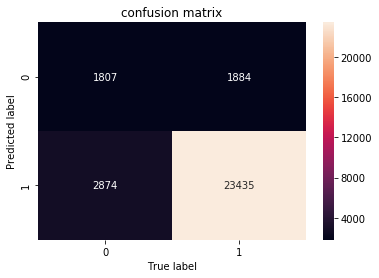

**********************************************************************

TNR= 0.3860286263618885
TPR= 0.9255894782574351
FPR= 0.6139713736381115
FNR= 0.07441052174256488
**********************************************************************

             precision    recall  f1-score   support

          0       0.39      0.49      0.43      3691
          1       0.93      0.89      0.91     26309

avg / total       0.86      0.84      0.85     30000

**********************************************************************



In [17]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val(n=30, n_jobs=-1, scoring='f1', x_train=x_train_tfidf, x_test=x_test_tfidf)

In [18]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(x_train_tfidf,y_train)
print('top 25 words and their IG---')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
feature=tfidf_vect.get_feature_names()
for i in range(25):
    index=s[i]
    print(feature[index],'\t\t:\t\t',round(top[index],5))

top 25 words and their IG---
throw 		:		 0.00565
refund 		:		 0.00567
one 		:		 0.00573
excel 		:		 0.00589
stale 		:		 0.00611
favorit 		:		 0.00637
thought 		:		 0.00662
use 		:		 0.00666
bad 		:		 0.00682
didnt 		:		 0.00698
horribl 		:		 0.00745
delici 		:		 0.00864
product 		:		 0.00876
perfect 		:		 0.00916
would 		:		 0.00948
good 		:		 0.01205
threw 		:		 0.01324
best 		:		 0.015
tast 		:		 0.01515
worst 		:		 0.01637
return 		:		 0.021
love 		:		 0.02228
wast 		:		 0.02608
great 		:		 0.02679
disappoint 		:		 0.03288


### Observation-
* we can choose depth=79 as a best hyperparameter for TFIDF

#### saving graph

In [20]:
import graphviz 
clf=DecisionTreeClassifier(max_depth=79)
clf.fit(x_train_tfidf,y_train)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=79,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [21]:
from sklearn import tree
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("graph_tfidf") 


'graph_tfidf.pdf'

## Decision tree classifier on avg word2vec, scoring='f1'

In [25]:
import urllib
url="https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
urllib.request.urlretrieve (url, "GoogleNews-vectors-negative300.bin.gz")

('GoogleNews-vectors-negative300.bin.gz',
 <http.client.HTTPMessage at 0x3fff3ef29080>)

In [23]:
import gensim

#getting the list of sentences in a 'list'
i=0
list_of_sentences=[]
for sent in X.values:
    filtered_sentence=[]    
    for w in sent.split():
        if(w==sent.split()[0]):
            w=w[2:]
        filtered_sentence.append(w.lower())       
    list_of_sentences.append(filtered_sentence)

In [24]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

2018-09-16 10:39:52,566 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2018-09-16 10:42:50,594 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


In [25]:
#defining a word2vec model
#model = gensim.models.KeyedVectors.load_word2vec_format(GoogleNews-vectors-negative300.bin.gz, binary=True)    
words=list(model.wv.vocab)
print(len(words))

3000000


In [26]:
#calculating avg word2vec
vectors=[];
for sentence in list_of_sentences:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence:
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    vectors.append(sentence_vector)

In [27]:
z=list(np.unique(np.where(np.isnan(vectors))[0]))
z

[10172, 13244, 13549, 33762, 39199, 45308, 54842]

In [28]:
vectors=np.delete(vectors, z, axis=0)
len(vectors)

69993

In [29]:
y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)
len(y_train_word)


69993

In [30]:
#calculating avg word2vec
x_test_word=[];
for sentence in x_test.values:
    sentence_vector=np.zeros(300)
    count_vec=0;
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        try:
            vec=model.wv[word]
            sentence_vector+=vec
            count_vec+=1;
        except:
            pass
    sentence_vector/=count_vec
    x_test_word.append(sentence_vector)

In [31]:
z=list(np.unique(np.where(np.isnan(x_test_word))[0]))
z

[9263, 19158]

In [32]:
x_test_word=np.delete(x_test_word, z, axis=0)
len(x_test_word)

29998

In [33]:
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)
len(y_test_word)

29998

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 140.6min finished


duration in cross validation= 2:20:56.715987
**********************************************************************

optimal depth 6
**********************************************************************



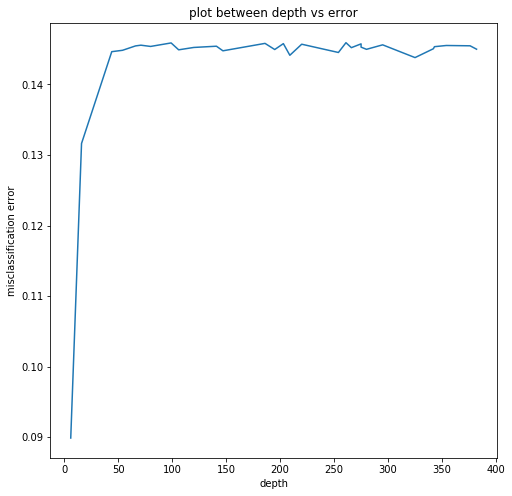

**********************************************************************

accuracy= 84.2756183745583
**********************************************************************

confusion matrix--


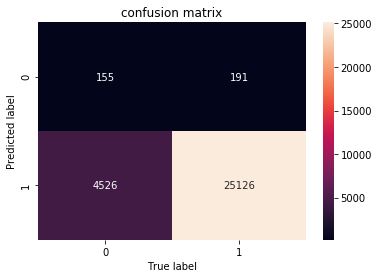

**********************************************************************

TNR= 0.033112582781456956
TPR= 0.9924556622032626
FPR= 0.9668874172185431
FNR= 0.0075443377967373704
**********************************************************************

             precision    recall  f1-score   support

          0       0.03      0.45      0.06       346
          1       0.99      0.85      0.91     29652

avg / total       0.98      0.84      0.90     29998

**********************************************************************



In [34]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val(n=30,  n_jobs=1, scoring='f1', x_train=vectors, x_test=x_test_word, y_train=y_train_word, y_test=y_test_word)

In [36]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(vectors,y_train_word)
print('top 25 IG---')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
for i in range(25):
    index=s[i]
    print(round(top[index],5))

top 25 IG---
0.00677
0.00689
0.00691
0.00777
0.00835
0.00853
0.00881
0.00896
0.00953
0.00973
0.01236
0.01532
0.0155
0.01729
0.01875
0.02718
0.02808
0.02997
0.04314
0.04726
0.07761
0.10889
0.12847
0.14467
0.16638


#### Observation-
* we can't find the important words for avg word2vec

## Decision tree classifier on avg word2vec, scoring='accuracy'

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 219.8min finished


duration in cross validation= 3:40:08.681878
**********************************************************************

optimal depth 5
**********************************************************************



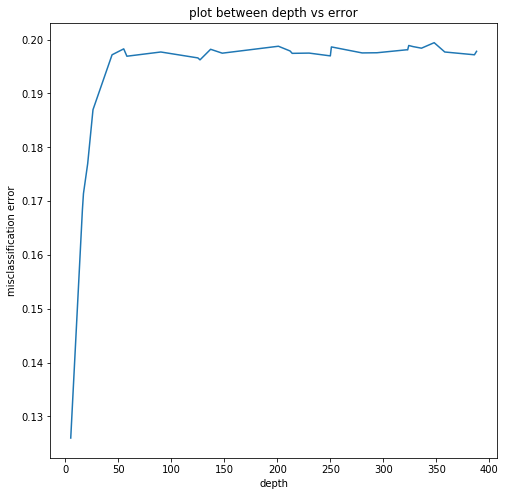

**********************************************************************

accuracy= 87.63835178023737
**********************************************************************

confusion matrix--


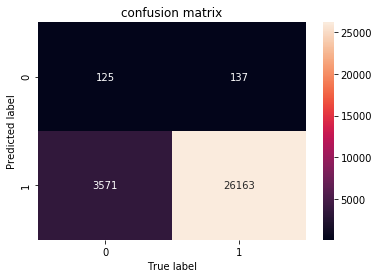

**********************************************************************

TNR= 0.03382034632034632
TPR= 0.9947908745247148
FPR= 0.9661796536796536
FNR= 0.005209125475285171
**********************************************************************

             precision    recall  f1-score   support

          0       0.03      0.48      0.06       262
          1       0.99      0.88      0.93     29734

avg / total       0.99      0.88      0.93     29996

**********************************************************************



In [145]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val( n_jobs=1, scoring='accuracy', x_train=vectors, x_test=x_test_word, y_train=y_train_word, y_test=y_test_word)

In [146]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(vectors,y_train_word)
print('top 25 IG---')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
for i in range(25):
    index=s[i]
    print(round(top[index],5))

top 25 IG---
0.0
0.0
0.0
0.0
0.0
0.0
0.00935
0.00967
0.01172
0.01353
0.0145
0.01605
0.0174
0.02346
0.02455
0.02568
0.02759
0.0483
0.04879
0.06371
0.06609
0.0963
0.13413
0.13933
0.20986


#### Observation-

* se can choose max_depth=6 as a good hyperparameter for word2vec


#### saving graph

In [37]:
clf=DecisionTreeClassifier(max_depth=6)
clf.fit(vectors,y_train_word)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [38]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("word2vec_graph") 


'word2vec_graph.pdf'

#### Observation-
* we can't find the important words for avg word2vec

## Decision tree classifier on tfidf avg word2vec, scoring='accuracy'

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,1))
x_train_tfidf=tfidf.fit_transform(X.values)
x_test_tfidf=tfidf.transform(x_test.values)

In [40]:
features=tfidf.get_feature_names()
len(features)
#features

27875

In [41]:
#calculating tf-idf w2vec
tfidf_vectors = []; 
row=0;
for sentence in list_of_sentences: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence: 
        try:
            vec = model.wv[word]
            tf_idf = x_train_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    tfidf_vectors.append(sentence_vec)
    row += 1

In [42]:
z=list(np.unique(np.where(np.isnan(tfidf_vectors))[0]))
tfidf_vectors=np.delete(tfidf_vectors, z, axis=0)
y_train_word=np.array(y_train)
y_train_word=np.delete(y_train_word, z, axis=0)

In [43]:
z=list(np.unique(np.where(np.isnan(tfidf_vectors))[0]))
z

[]

In [45]:
#calculating tf-idf w2vec
x_test_tf_word = []; 
row=0;
for sentence in x_test.values: 
    sentence_vec = np.zeros(300) 
    weight_sum =0; 
    for word in sentence.split():
        if(word==sentence.split()[0]):
            word=word[2:]
        try:
            vec = model.wv[word]
            tf_idf = x_test_tfidf[row, features.index(word)]
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sentence_vec /= weight_sum
    x_test_tf_word.append(sentence_vec)
    row += 1

In [46]:
z=list(np.unique(np.where(np.isnan(x_test_tf_word))[0]))
x_test_tf_word=np.delete(x_test_tf_word, z, axis=0)
y_test_word=np.array(y_test)
y_test_word=np.delete(y_test_word, z, axis=0)

In [47]:
len(y_train_word)

69993

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 166.1min finished


duration in cross validation= 2:46:51.101344
**********************************************************************

optimal depth 14
**********************************************************************



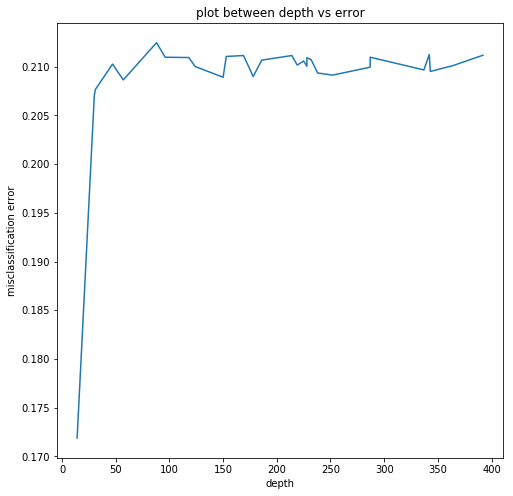

**********************************************************************

accuracy= 83.35444725963463
**********************************************************************

confusion matrix--


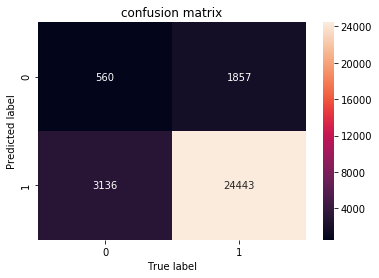

**********************************************************************

TNR= 0.15151515151515152
TPR= 0.9293916349809886
FPR= 0.8484848484848485
FNR= 0.07060836501901141
**********************************************************************

             precision    recall  f1-score   support

          0       0.15      0.23      0.18      2417
          1       0.93      0.89      0.91     27579

avg / total       0.87      0.83      0.85     29996

**********************************************************************



In [155]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val( n_jobs=1, scoring='accuracy', x_train=tfidf_vectors, x_test=x_test_tf_word, y_train=y_train_word, y_test=y_test_word)

In [156]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(vectors,y_train_word)
print('top 25 IG---')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
for i in range(25):
    index=s[i]
    print(round(top[index],5))

top 25 IG---
0.00615
0.00619
0.00619
0.00622
0.00653
0.00656
0.0067
0.00688
0.00764
0.0077
0.00798
0.00802
0.00827
0.00834
0.01027
0.01056
0.01125
0.01138
0.01306
0.0135
0.0147
0.02187
0.02621
0.02809
0.02906


#### Observation-
* we can't find important words for tfidf word2vec

## Decision tree classifier on tfidf avg word2vec, scoring='f1'

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 146.5min finished


duration in cross validation= 2:26:34.197512
**********************************************************************

optimal depth 1
**********************************************************************



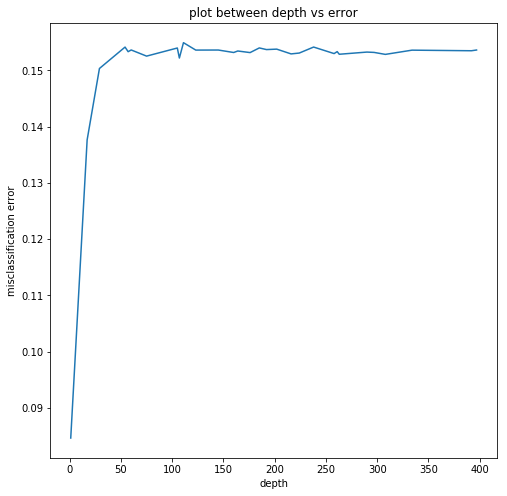

**********************************************************************

accuracy= 84.39562637509167
**********************************************************************

confusion matrix--


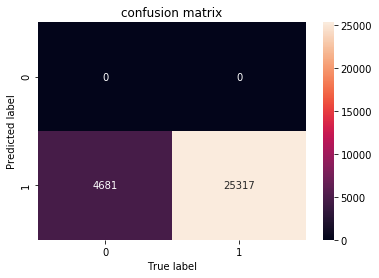

**********************************************************************

TNR= 0.0
TPR= 1.0
FPR= 1.0
FNR= 0.0
**********************************************************************

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.84      0.92     29998

avg / total       1.00      0.84      0.92     29998

**********************************************************************



In [48]:
optimal_depth, accu, TNR, TPR, FPR, FNR=cross_val( n=30, n_jobs=1, scoring='f1', x_train=tfidf_vectors, x_test=x_test_tf_word, y_train=y_train_word, y_test=y_test_word)

In [49]:
#feature importance
clf=DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(tfidf_vectors,y_train_word)
print('top 25 IG---')
top=clf.feature_importances_
s=np.argsort(top)[-25:]
for i in range(25):
    index=s[i]
    print(round(top[index],5))

top 25 IG---
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0


#### Observation-
* we can't find important words for tfidf word2vec

#### Observation-
* we can choose max_depth=14 as a good hyperparameter for Tfidf Word2vec

#### saving graph

In [50]:
clf=DecisionTreeClassifier(max_depth=14)
clf.fit(tfidf_vectors,y_train_word)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [51]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("tfidf_word2vec_graph") 


'tfidf_word2vec_graph.pdf'

# Performance Table

| sno 	| featurization  	| scoring  	| optimal depth 	| accuracy 	| TNR    	| TPR    	| f1-score 	|
|-----	|----------------	|----------	|---------------	|----------	|--------	|--------	|----------	|
| 1   	| Bag of words   	| f1       	| 62            	| 84.7966  	| 0.3623 	| 0.9377 	| 0.86     	|
| 2   	| Bag of words   	| accuracy 	| 12            	| 88.7033  	| 0.1693 	| 0.9878 	| 0.92     	|
| 3   	| Tfidf          	| accuracy 	| 6             	| 88.4833  	| 0.1241 	| 0.9917 	| 0.92     	|
| 4   	| Tfidf          	| f1       	| 79            	| 84.14    	| 0.3860 	| 0.9255 	| 0.85     	|
| 5   	| Avg word2vec   	| f1       	| 6             	| 84.2756  	| 0.0331 	| 0.9924 	| 0.90     	|
| 6   	| Avg word2vec   	| accuracy 	| 5             	| 87.6385  	| 0.0338 	| 0.9947 	| 0.93     	|
| 7   	| Tfidf Word2Vec 	| accuracy 	| 14            	| 83.3544  	| 0.1515 	| 0.9293 	| 0.85     	|
| 8   	| Tfidf Word2Vec 	| f1       	| 1             	| 84.9356  	| 0.0    	| 1.0    	| 0.92     	|

# Conclusion-
* We have applied Decision Tree on amazon fine food review.
* Normalization should have no impact on the performance of a decision tree. So we didn't use it.
* We applied four featurization techniques- BoW, Tfidf, Avg word2vec and Tfidf word2vec for Decision Tree.
* As we can see that TNR is so bad especially in case of avg word2vec models.
* So we can conclude that decision tree is not working weel in case when dimension is high.